In [225]:
# Import required packages

import os
import warnings
import absl.logging
from glob import glob

absl.logging.set_verbosity(absl.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import box
import rioxarray as rxr
from rasterio.plot import plotting_extent
import rasterio as rio
from rasterio.windows import Window
import earthpy.plot as ep

import sklearn as skl
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow_examples.models.pix2pix import pix2pix

data_dir = os.path.join(os.path.expanduser('~'), 'GitHub', 'NathanKorinekNeuralNetsProject')

In [226]:
def normalize_image(image):
    """
    Function to normalize RGB images
    """
    return image/255.0

def make_glacier_mask(image, glacier_boundaries):
    """
    Function that takes an image and the boundaries of a glacier, and
    then creates an output with a 1 where there are glaciers, and a 0 
    where there are not
    """
    bounds = box(*image.rio.bounds())
    glacier_clip = glacier_boundaries.clip(bounds)
    clipped_image = image.rio.clip(glacier_boundaries.geometry, drop=False)
    clipped_image_fill = clipped_image[0].fillna(254)
    clipped_image_1s = xr.where(clipped_image_fill!=254, 1, 0)
    return clipped_image_1s, glacier_clip

def make_clip_geom(im_bounds, glacier_boundaries):
    """Function to get the glacier boundaries within an image"""
    bounds = box(*im_bounds)
    glacier_clip = glacier_boundaries.clip(bounds)
    return glacier_clip 

def tile_image(input_path, output_path, im_name, tile_size):
    """Function that tiles input images to make them the appropriate size for model"""
    with rio.open(input_path) as src:
        height, width = src.shape
        for row in range(0, height, tile_size):
            for col in range(0, width, tile_size):
                window = Window(col, row, tile_size, tile_size)
                tile = src.read(window=window)
                # Treat differently if it's a mask or an RGB image
                if 'mask' in input_path:
                    count = 1
                else:
                    count = 3
                tile_output_path = "{}/tile_{}_{}_{}.tif".format(output_path, im_name[:-4], row, col)
                with rio.open(tile_output_path, 'w', driver='GTiff', height=tile_size, width=tile_size, count=count, dtype=src.dtypes[0], crs=src.crs, transform=src.window_transform(window)) as dst:
                    dst.write(tile)

def load_data(image_folder, mask_folder, verbose=False):
    """Function to read tile files into an array that can be put into a model"""
    images = []
    masks = []
    good_files = []


    image_files = sorted(glob(os.path.join(image_folder, "*.tif")))
    mask_files = sorted(glob(os.path.join(mask_folder, "*.tif")))

    for i, file in enumerate(image_files):
        if i%2000 == 0 and verbose:
            print("On file {} of {}".format(i, len(image_files)))

        with rio.open(mask_files[i]) as mask_file:
            mask = mask_file.read(1)
        if mask.sum() > 0:
            # Read and transpose to (128, 128, 3)
            with rio.open(file) as img_file:
                img = img_file.read().transpose(1, 2, 0)  

            images.append(img)
            masks.append(mask)
            good_files.append(os.path.basename(os.path.normpath(file)))
    return np.array(images), np.array(masks), good_files

def untile_image(mask_image, predictions, valid_files, img_name):
    """Function to create full images from model output"""
    shape = mask_image.shape
    untiled_image_1 = np.zeros(mask_image.shape)
    untiled_image_2 = np.zeros(mask_image.shape)
    for i, file in enumerate(valid_files):
        tile_info = file.split('.')[0].split('_')
        image, row, col = tile_info[-3], int(tile_info[-2]), int(tile_info[-1])
        if image == img_name:
            pred_im1 = np.logical_not(predictions[i].transpose(2, 1, 0)[0]).astype(int)
            pred_im2 = predictions[i].transpose(2, 1, 0)[1]
            pred_im1 = np.flip(np.rot90(pred_im1, 3), 1)
            pred_im2 = np.flip(np.rot90(pred_im2, 3), 1)
            if row+128 <= shape[0] and col+128 <= shape[1]:
                untiled_image_1[row:row+128, col:col+128] = pred_im1
                untiled_image_2[row:row+128, col:col+128] = pred_im2

    return untiled_image_1, untiled_image_2

def unet_model(output_channels:int):
    """Helper function to create our UNet model from pix2pix and MobileNetV2"""
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [227]:
# Define desired bands
variables = ['B2', 'B8', 'B11']

# Open Glacier Data
glacier_shape_path = os.path.join(data_dir, 'glaciersurveychile2022_v2', 'IPG2022_v2.shp')
glaciers = gpd.read_file(glacier_shape_path).to_crs('EPSG:3857')

In [228]:
# Create masks 

# Create needed directories
glacier_dir = os.path.join(data_dir, 'satellite_images')
mask_dir = os.path.join(data_dir, 'mask_images')
reduced_dir = os.path.join(data_dir, 'satellite_images_reduced')

glacier_images = sorted(glob(os.path.join(glacier_dir, '*.tif')))
masks = sorted(glob(os.path.join(mask_dir, '*.tif')))

directories = [glacier_dir, mask_dir, reduced_dir]

for dirs in directories:
    if not os.path.isdir(dirs):
        os.mkdir(dirs)

mask_images = []
clips = []
reduced_images = []
bounds = []
# Reduce images and create masks
if len(masks) == 0:
    for image_path in glacier_images:
        print("Processing {}".format(image_path))
        # Select only desired bands and write to raster
        image = rxr.open_rasterio(image_path, variable=variables).sel(band=[2, 8, 11])
        image = image.rio.set_attrs({'long_name': ['B2', 'B8', 'B11']})
        reduced_image_path = os.path.join(data_dir, 'satellite_images_reduced', os.path.basename(os.path.normpath(image_path)))
        image.rio.to_raster(reduced_image_path)
        reduced_images.append(reduced_image_path)
        # Create masks for images with binary glacier classification
        mask, clip = make_glacier_mask(image, glaciers)
        mask_path = image_path.replace("satellite_images", "mask_images")[:-4]+"_mask.tif"
        mask.rio.to_raster(mask_path)
        mask_images.append(mask_path)
    mask_images = sorted(mask_images)
    reduced_images = sorted(reduced_images)
else:
    mask_images = sorted(masks)
    reduced_images = sorted(glob(os.path.join(data_dir, 'satellite_images_reduced', "*.tif")))

In [229]:
# Pick 2 images for testing, and 6 for training
training_images = reduced_images[:6]
testing_images = reduced_images[6:]

training_masks = mask_images[:6]
testing_masks = mask_images[6:]

# Create tile directories
tiles = [testing_images, training_images, testing_masks, training_masks]
tiles_dirs = [os.path.join(data_dir, 'data', 'test_tiles'), 
            os.path.join(data_dir, 'data', 'train_tiles'), 
            os.path.join(data_dir, 'data', 'mask_test_tiles'), 
            os.path.join(data_dir, 'data', 'mask_train_tiles')]

# Making lists for data
training_list, testing_list, mask_training_list, mask_testing_list = [], [], [], []
tiles_list = [training_list, testing_list, mask_training_list, mask_testing_list]
array_names = ['training_array', 'testing_array', 'mask_training_array', 'mask_testing_array']

for dirs in tiles_dirs:
    if not os.path.isdir(dirs):
        os.mkdir(dirs)

In [230]:
# Checking if tiles exist
test_tiles_dir = glob(os.path.join(tiles_dirs[0], "*.tif"))

if len(test_tiles_dir) == 0:
    tile_size = 128
    for i, tile_dir in enumerate(tiles_dirs):
        image_list = tiles[i]
        for image_path in image_list:
            # Tile all images and masks
            name = os.path.basename(os.path.normpath(image_path))
            print("Creating tiles for image {}".format(name))
            tile_image(image_path, tile_dir, name, tile_size)

In [231]:
# Load tiles into arrays
test_images, test_masks_bad, test_files = load_data(tiles_dirs[0], tiles_dirs[2])
train_images, train_masks_bad, train_files = load_data(tiles_dirs[1], tiles_dirs[3])

In [232]:
# Reshape masks to be correct dimensions

train_masks = train_masks_bad[..., np.newaxis]
test_masks = test_masks_bad[..., np.newaxis]

In [233]:
# Modified from tutorial here: https://www.tensorflow.org/tutorials/images/segmentation

# Use MobileNetV2 as encoder
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Make MobileNetV2 not trainable so it trains on the pix2pix side of the model
down_stack.trainable = False

In [234]:
# Making a decoder from the pix2pix model
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [235]:
# Creating and compiling the model
model = unet_model(output_channels=2)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [236]:
# Setting hyper parameters of model
batch_size = 65
steps_per_epoch = len(train_masks) // batch_size

# Fitting model to data
model_history = model.fit(train_imacenterges, train_masks, epochs=10,
                        steps_per_epoch=steps_per_epoch, verbose=0)


In [237]:
# Evaluating model accuracy on test data
loss, accuracy = model.evaluate(test_images, test_masks, verbose=0)

In [238]:
# Predicting glacial extents on test images
predictions = model.predict([test_images], verbose=0)

In [239]:
binary_predictions = np.where(predictions > 0, 1, 0)

In [240]:
test_7_path = os.path.join(data_dir, "mask_images", "mini_s2_test7_mask.tif")
test_8_path = os.path.join(data_dir, "mask_images", "mini_s2_test8_mask.tif")
path_7 = os.path.join(data_dir, "satellite_images_reduced", "mini_s2_test7.tif")
path_8 = os.path.join(data_dir, "satellite_images_reduced", "mini_s2_test8.tif")

with rio.open(test_7_path) as src:
    test_7_array = src.read(1)
    test_7_extent = plotting_extent(src)
    test_7_bounds = src.bounds

with rio.open(test_8_path) as src:
    test_8_array = src.read(1)
    test_8_extent = plotting_extent(src)
    test_8_bounds = src.bounds

with rio.open(path_7) as src:
    array_7 = src.read()

with rio.open(path_8) as src:
    array_8 = src.read()

final7_1, final7_2 = untile_image(test_7_array, binary_predictions, test_files, "test7")
final8_1, final8_2 = untile_image(test_8_array, binary_predictions, test_files, "test8")

In [241]:
glaciers_7 = make_clip_geom(test_7_bounds, glaciers)
glaciers_8 = make_clip_geom(test_8_bounds, glaciers)

In [242]:
ex_image_path = os.path.join(data_dir, 'satellite_images', 'mini_s2_test3.tif')
with rio.open(ex_image_path) as src:
    ex_image = src.read()
    ex_bounds = src.bounds
    ex_extent = plotting_extent(src)

ex_mask_path = os.path.join(data_dir, 'mask_images', 'mini_s2_test3_mask.tif')
with rio.open(ex_mask_path) as src:
    ex_mask = src.read(1)

ex_geom = make_clip_geom(ex_bounds, glaciers)

# Introduction

Glaciers play a very important role in water access globally. The freshwater that comes from glaciers is crucial to many communities in
glaciated areas, and for many people downstream from glaciers as well. This is especially true in the Andean region of South America, which has many large glaciers that provide resources for people in Chile (Hagen et al. 2022). Over the last few decades, glaciers in the Andes have been retreating at rapid rates (Huss et al. 2017). This will have massive impacts on people in the region that need the glacial runoff consistently to live. 

When looking at the retreat of glaciers in general, it is often understood through a concept called glacial mass balance. It takes into account how much snow and ice have accumulated and melted/sublimated away from glaciers on a year to year basis (Price et al. 2022). Conceriningly, the Southern Andes were found by Zemp et al. 2019 to be losing glacial mass more quickly than anywhere else globally. This region is of utmost concern when looking at the effects of climate change.

The future is bleak for this area in more ways than just glacial retreat. The area is estimated to lose at least 35% of its snow pack before 2100. This is the best case scenario, if emissions don’t curb soon, it is projected the Andes could lose 85% of its snow pack (Bozkurt et al. 2018). In addition to snow pack loss, under every climate scenario, the precipitation is expected to drop. The Andes will be hotter and drier than ever, leading to large changes in glacial mass (Bozkurt et al. 2018).  

With the region changing so rapidly, knowing exactly which areas have lost access to water resources can be a crucial factor in mitigating negative consequences. The Chilean government conducts glacial inventories in order to know what freshwater resources it has. They create this data by having a team of experts go over imagery and identify where glaciers exist in the country. The problem with this method is that it has a heavy cost, both in terms of capital and labor. The last public inventory was conducted in 2006. I have gotten early access to the data they hope to publish soon, but even this is based on imagery from 2019. 

With this project I hope to create a tool that can be used by Chileans and people interested in Chilean water management. Using the glacial inventory combined with satellite data, I want to create a model that can show where glaciers exist in Chile in real time. Instead of waiting decades for updated metrics, I hope this model will give people a way to estimate glacial area between inventories. The goal is to make resource management easier and give a tool to people that can inform their decisions. 


# Data and Prep

In order to create a more accurate glacial inventory of Chile, I combined Sentinel 2 satellite multispectral data with a recent glacial survey of Chile. The glacial survey was created by experts in Chile using multiple data sources, and is fairly accurate to the year the inventory was taken. The data was created based on where the glaciers were in 2019. Using Google Earth Engine, I downloaded an area of Chile that has a high density of glaciers. The area was focused around Parque Nacional Laguna San Rafael, a national park in the south of Chile. The images were collected from between January and February of 2019, it is a composite of images that have the least cloud cover during those dates, showing a whole picture of the region largely uninterupted by clouds.


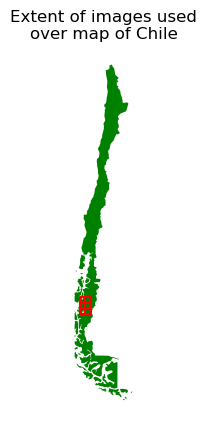

In [243]:
bounds = []

for im in glacier_images:
    with rio.open(im) as src:
        bounds.append(gpd.GeoSeries(box(*src.bounds)))

chile = gpd.read_file(os.path.join(data_dir, "data", "chile", "chile.shp")).to_crs(glaciers.crs)

fig, ax = plt.subplots()

chile.plot(color='green', ax=ax)
ax.set(title="Extent of images used\nover map of Chile", xticks=[], yticks=[])

for bound in bounds:
    bound.boundary.plot(ax=ax, color='red')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()


Initially I had issues with the data being skewed, as it was projected data, meaning the arrays had a lot of missing values. I fixed this by reprojecting the data into a Web Mercator projection, which turns the earth into a perfectly rectangular map. This is innaccurate spatially, but for my purposes of identifying glaciers it was a good solution to normalize the shape of the data. Usually, Sentinel 2 data is 10 meter by 10 meter resolution, meaning that each pixel in the image is 10x10 meters area, but due to the projection the pixels did not represent a consistent area. 

Once I had the data in a more useable spatial projection, I was able to view it. Sentinel 2 data has 12 bands of light that it collects, ranging from ultraviolet light, going through the visible spectrum, and extending far into the infrared. Since I knew I would try to use a pre-trained model when creating my model, I wanted to get the data down to 3 bands of radiation instead of 12. I picked Band 2 (visible blue light, 490 nm wavelength), Band 8 (near infrared light, 842 nm wavelength), and Band 11 (short wave infrared light, 1610 nm wavelength). 

![Sentinel 2 Spectral Bands](https://www.researchgate.net/profile/Darko-Jaramaz/publication/267981491/figure/fig1/AS:392247746023450@1470530558491/Sentinel-2-spectral-bands-Martimort-et-al-2007.png)

This image displays the spectral bands on Sentinel 2 and what they can be used for (Jaramaz et al. 2013)

The three wavelengths I chose were able to hightlight glaciers against almost every other type of land cover, as can be seen below when looking at the false color image I made with the three wavelengths I chose. I have overlaid the glacial inventory from the chilean government over top of the images. As you can see, there is large agreement between the inventory and where the glaciers are visually. 

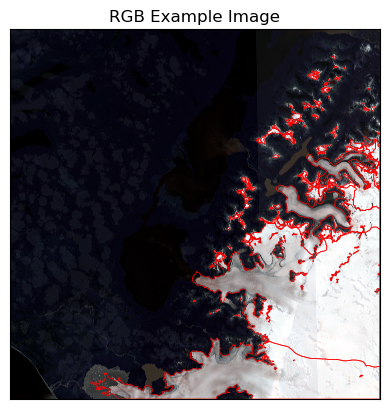

In [244]:
fig, ax = plt.subplots()

ep.plot_rgb(ex_image, [2, 3, 4], ax=ax, extent=ex_extent, title="RGB Example Image", stretch=True)
ex_geom.boundary.plot(color='red', linewidth=.5, ax=ax)

plt.show()

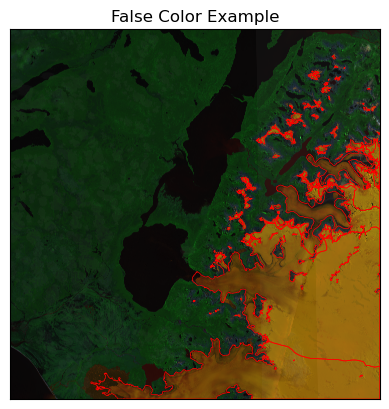

In [245]:
fig, ax = plt.subplots()

ep.plot_rgb(ex_image, [2, 8, 11], ax=ax, extent=ex_extent, title="False Color Example")
ex_geom.boundary.plot(color='red', linewidth=.5, ax=ax)

plt.show()

Using the glacial outlines, I created numpy arrays that were a binary classifier. I put a 1 in areas with glaciers, and a 0 in areas without. This will be used as my y data, what I hope the model is able to output. 

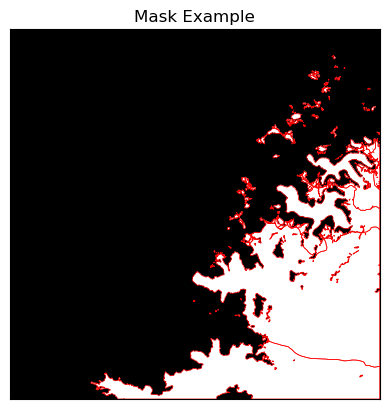

In [246]:
fig, ax = plt.subplots()

ax.imshow(ex_mask, cmap='gray', extent=ex_extent)
ex_geom.boundary.plot(color='red', linewidth=.5, ax=ax)
ax.set(title="Mask Example", xticks=[], yticks=[])

plt.show()

With the data down to three bands and the mask data created, I tiled the data, breaking it up into arrays of size 128x128. The 3 band imagery was 3x128x128. I wrote all of these tiles out to files so that I can open them and stack them into useable data at any point. 

In order to split into training and testing data, I manually picked images to be opened as "training" while others were opened as "testing". The 8 images that made up my study area were all roughly equivalently size, so I chose 2 of them to be testing data, while the remaining 6 were designated as the training images. 

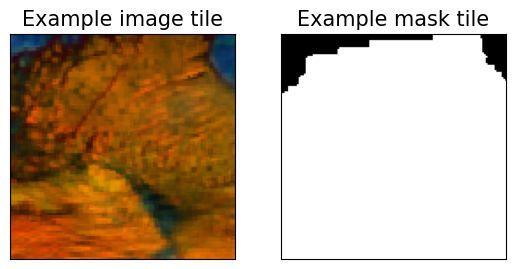

In [247]:
fig, [ax1, ax2] = plt.subplots(1, 2)

# Plotting image
ep.plot_rgb(test_images[382].transpose(2, 1, 0), ax=ax1)
ax1.set_title('Example image tile', size=15)

# Plotting mask
ax2.imshow(np.flip(np.rot90(test_masks[382], 3), 1), cmap='gray')
ax2.set_title('Example mask tile', size=15)
ax2.set(xticks=[], yticks=[])

plt.show()

The tiles are helpful, but in order to put my data into the model, I needed to perform some adjustments to the shapes of the arrays. The 3 band images needed to be transposed in order to fit in the model. 

In [248]:
with rio.open(test_tiles_dir[0]) as src:
    tile_shape = src.read()

print("Single tile input data shape before transposing: {}".format(tile_shape.shape))
print("Single tile input data shape after transposing: {}".format(test_images[0].shape))

Single tile input data shape before transposing: (3, 128, 128)
Single tile input data shape after transposing: (128, 128, 3)


Besides that, I also had to add a false dimension to the mask data in order to ensure that it matches the input data's dimensions.

In [249]:
print("Testing mask input data shape before transposing: {}".format(test_masks_bad.shape))
print("Training mask input data shape before transposing: {}".format(train_masks_bad.shape))

print("Testing mask input data shape after transposing: {}".format(test_masks.shape))
print("Training mask input data shape after transposing: {}".format(train_masks.shape))

Testing mask input data shape before transposing: (2253, 128, 128)
Training mask input data shape before transposing: (7995, 128, 128)
Testing mask input data shape after transposing: (2253, 128, 128, 1)
Training mask input data shape after transposing: (7995, 128, 128, 1)


After all of the data transpositions, the final shapes of all of the data looked like so. 

In [250]:
print("Training Data Shape: {}".format(train_images.shape))
print("Training Mask Data Shape: {}".format(train_masks.shape))

print("Testing Data Shape: {}".format(test_images.shape))
print("Testing Mask Data Shape: {}".format(test_masks.shape))

Training Data Shape: (7995, 128, 128, 3)
Training Mask Data Shape: (7995, 128, 128, 1)
Testing Data Shape: (2253, 128, 128, 3)
Testing Mask Data Shape: (2253, 128, 128, 1)


# Model and Methods

In order to build my model, I wanted to use pre-trained models so I wasn't starting the training from scratch. I based my model on a [segmentation tutorial](https://www.tensorflow.org/tutorials/images/segmentation) that tensorflow has on their tutorials page. I had to make modifications to the model in order to input my data specifically. 

The model uses the pre-trained MobileNetV2 model in order to encode the input data. Interestingly, the tutorial recommended not letting the encoder train, setting the trainable parameter to false within the encoder. This made it so the model did not learn while encoding input data, it only learned while it was decoding the data into a mask. This lead to great results when using the model, as well as significantly improving it's training time. 

The decoder section of the model is based on the pix2pix pre-trained model, which is a conditional generative adversarial network (GAN). This GAN is able to take the encoded data and upsamples it to look like what the output should look like. 

Using convolution is very helpful with spatial data, as it makes the model consider the spatiality of the pixel when classifying. Due to the way the data is encoded, each value is affected by it's neighbors, making it less likely to classify single pixels as glaciers in areas that have none. 

Both of these together make a structure very similar to U-Net architecture. I had to change the encoder in order to accept my data specifically, while I modified the decoder to be a binary classification output, using a sigmoid activation function in order to classify whether a pixel is a glacier or not. 

The final structure of the model with the encoder and decoder combined is shown below. The model starts to train where on the layer shown as "sequential_4".

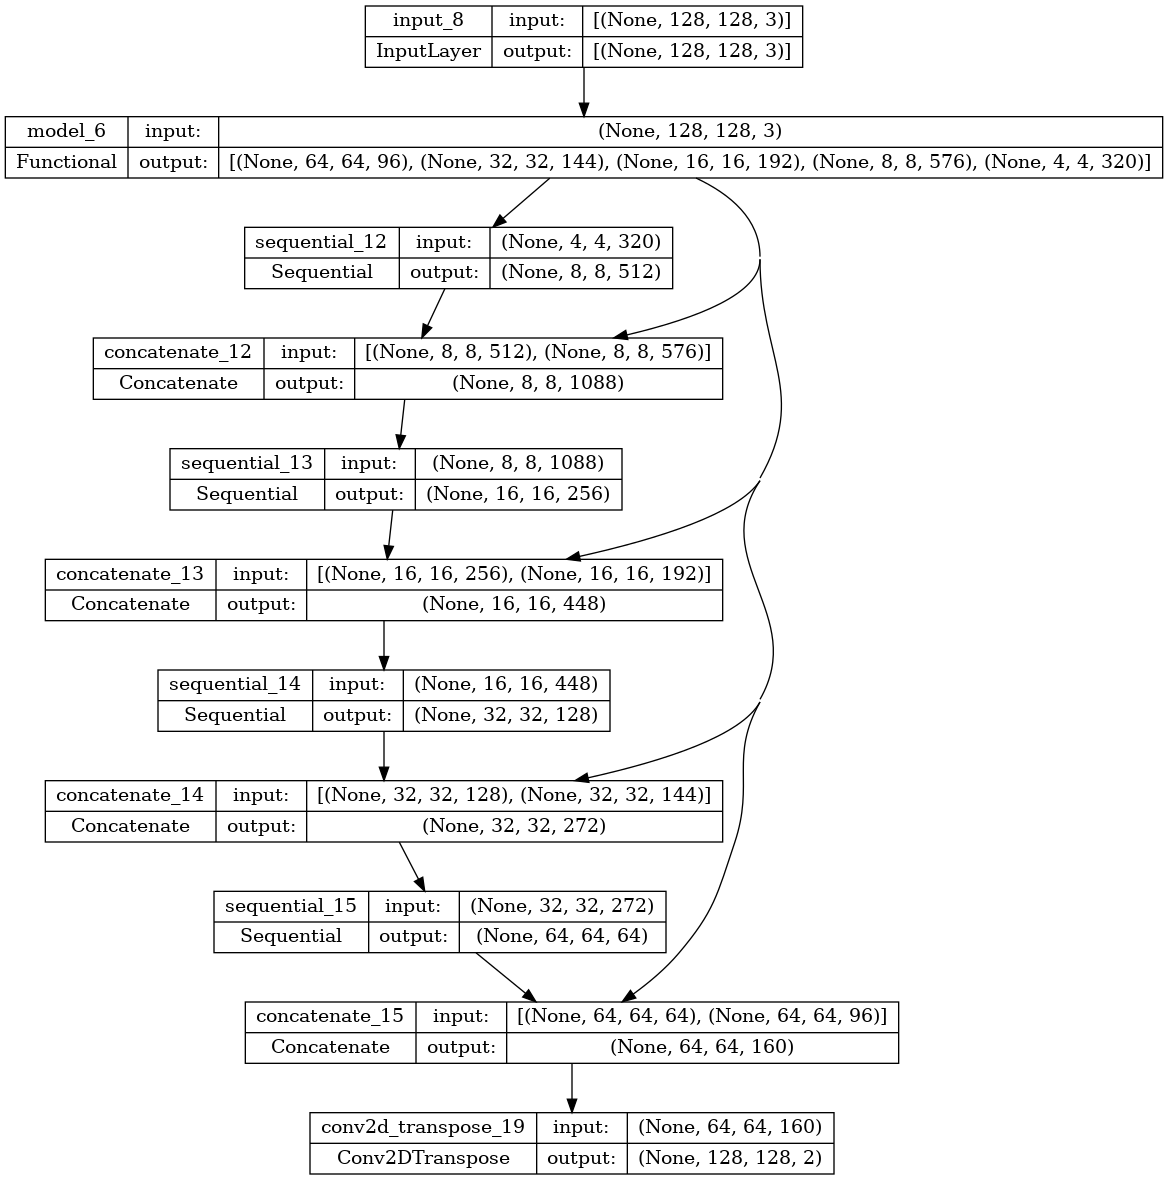

In [251]:
tf.keras.utils.plot_model(model, show_shapes=True)

I let the model run for 10 epochs, usually taking 10-15 minutes to run completely on my local machine. As you can see, the model's accuracy starts out high, and climbs rapidly during the first epoch, then makes slow but steady progress upwards as the epochs continue. The loss of the model has a similar curve but in reverse. The high initial accuracy is likely due to using two pre-trained models to construct this model. 

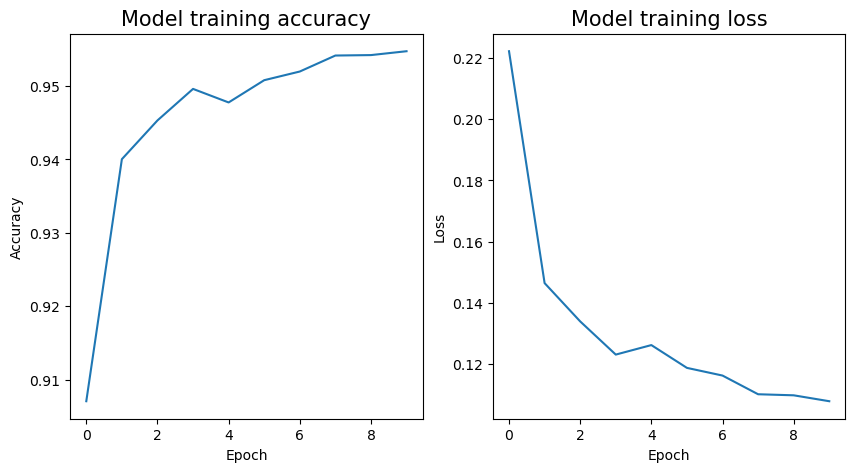

In [252]:
fig, [ax, ax2] = plt.subplots(1, 2, figsize = (10, 5))

ax.plot(model_history.history['accuracy'])
ax.set_title('Model training accuracy', size=15)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')

ax2.plot(model_history.history['loss'])
ax2.set_title('Model training loss', size=15)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

plt.show()

In [253]:
binary_1, binary_2, mask_true = [], [], []

for i, row in enumerate(binary_predictions):
    binary_1.append(row.transpose(2, 1, 0)[0])
    binary_2.append(row.transpose(2, 1, 0)[0])
    mask_true.append(np.flip(np.rot90(test_masks[i], 3)))
mask_true = np.array(mask_true)
binary_1 = np.array(binary_1)
binary_2 = np.array(binary_2)

# Results

The model ended with a 95.5% accuracy on the training data, which translated to roughly 93% accuracy on the testing data when predicting values.

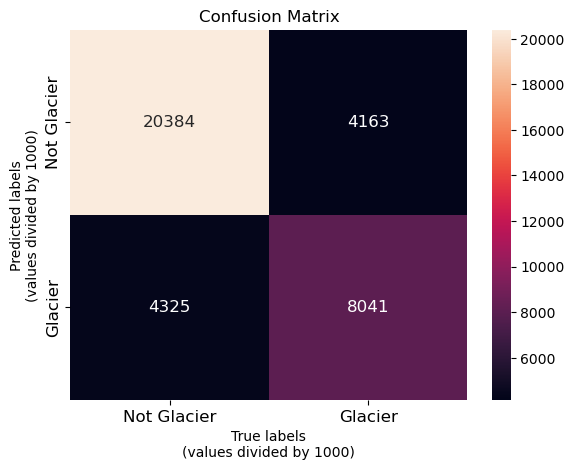

In [254]:
cm_pred, cm_true = np.logical_not(binary_2.flatten()).astype(int), mask_true.flatten()
cm = confusion_matrix(cm_true, cm_pred)

cm = np.round(cm/1000).astype(int)

fig, ax1 = plt.subplots()
# ANN Confusion matrix
sns.heatmap(cm, annot=True, fmt='g', ax=ax1, annot_kws={'size': 12})

vals = ['Not Glacier', 'Glacier']

ax1.set_xlabel('True labels\n(values divided by 1000)') 
ax1.set_ylabel('Predicted labels\n(values divided by 1000)')
ax1.set_title('Confusion Matrix') 
ax1.xaxis.set_ticklabels(vals, fontsize = 12)

ax1.yaxis.set_ticklabels(vals, fontsize = 12)
plt.show()

In order to create the final images, I had to turn the output into a true false boolean, like the masks I have. The output ranged from roughly -10 to 10, centered around 0. It is a very clear bimodal distribution, and when looking closely the bottom of the saddle in between the two peaks is almost exactly 0. Due to this, I chose to call any value above 0 a glacier, and any value below zero not a glacier. 

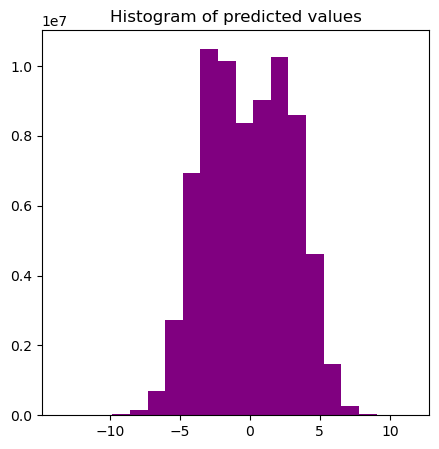

In [255]:
ep.hist(predictions.flatten(), figsize=(5, 5), title="Histogram of predicted values");

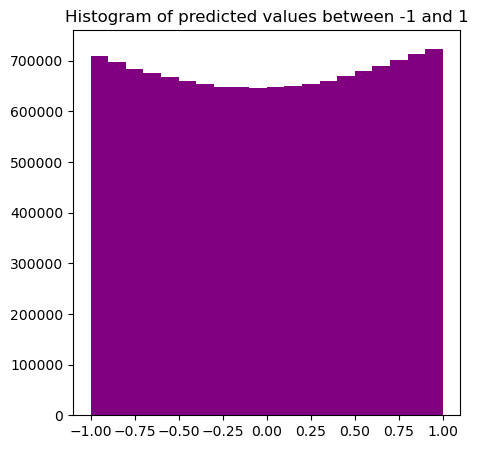

In [256]:
ep.hist(predictions.flatten(), hist_range=[-1, 1], figsize=(5, 5), title="Histogram of predicted values between -1 and 1");

After all of this processing, I had to undo all of the transpositions I initially performed on the data in order to get clear images of what the model actually predicted. The model returned 2 layers, one for where it believed glaciers were, and another for where they weren't. As this was a binary classification problem, those two layers were nearly identical. I chose to use the one showing where glaciers were when evaluating the model's performance. 

In [257]:
diff = ((final7_2 - final7_1).sum() + (final8_2 - final8_1).sum())/(final7_1.size + final8_1.size)

diff_perc = round(diff*100, 2)

print("Percent difference between model's output layers: {}%".format(diff_perc))

Percent difference between model's output layers: -0.57%


The results look great. The imagery does not perfectly align with the glacial shapes in the inventory. This can be due to different timing of my images compared to when they collect, or many other factors. It is fairly visible in my predictions that they line up well with the false color imagery, and line up fairly well against the inventory data. In order to get a better picture overall I would like to run a smoothing filter over the output in order to make it a more clear image, but overall it visually looks like it was able to find the glaciers very well. 

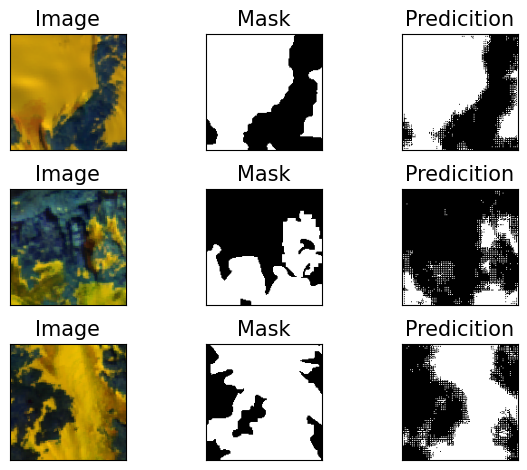

In [258]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]] = plt.subplots(3, 3)

# Plotting image
ep.plot_rgb(test_images[5].transpose(2, 1, 0), ax=ax1)
ax1.set_title('Image', size=15)

# Plotting mask
ax2.imshow(np.flip(np.rot90(test_masks[5], 3), 1), cmap='gray')
ax2.set_title('Mask', size=15)
ax2.set(xticks=[], yticks=[])

# Plotting prediction
ax3.imshow(binary_predictions[5].transpose(2, 1, 0)[1], cmap='gray')
ax3.set_title('Predicition', size=15)
ax3.set(xticks=[], yticks=[])

# Plotting image
ep.plot_rgb(test_images[700].transpose(2, 1, 0), ax=ax4)
ax4.set_title('Image', size=15)

# Plotting mask
ax5.imshow(np.flip(np.rot90(test_masks[700], 3), 1), cmap='gray')
ax5.set_title('Mask', size=15)
ax5.set(xticks=[], yticks=[])

# Plotting prediction
ax6.imshow(binary_predictions[700].transpose(2, 1, 0)[1], cmap='gray')
ax6.set_title('Predicition', size=15)
ax6.set(xticks=[], yticks=[])

# Plotting image
ep.plot_rgb(test_images[2000].transpose(2, 1, 0), ax=ax7)
ax7.set_title('Image', size=15)

# Plotting mask
ax8.imshow(np.flip(np.rot90(test_masks[2000], 3), 1), cmap='gray')
ax8.set_title('Mask', size=15)
ax8.set(xticks=[], yticks=[])

# Plotting prediction
ax9.imshow(binary_predictions[2000].transpose(2, 1, 0)[1], cmap='gray')
ax9.set_title('Predicition', size=15)
ax9.set(xticks=[], yticks=[])

plt.tight_layout()
plt.show()

I was able to reconstruct the original mask images from the prediction data, and looking at the whole map the predictions hold up and align well with the boundaries provided.  

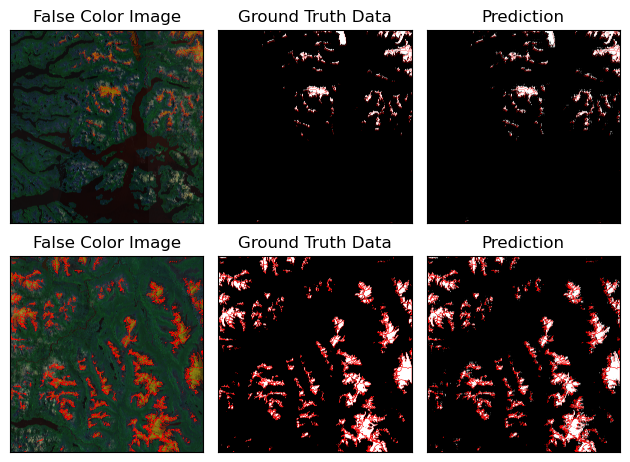

In [259]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3)

ep.plot_rgb(array_7, ax=ax1, title="False Color Image", extent=test_7_extent)
ax2.imshow(test_7_array, extent=test_7_extent, cmap='gray')
ax2.set(title="Ground Truth Data", xticks=[], yticks=[])
ax3.imshow(final7_1, extent=test_7_extent, cmap='gray')
ax3.set(title="Prediction", xticks=[], yticks=[])
axes = [ax1, ax2, ax3]
for ax in axes:
    glaciers_7.boundary.plot(color='red', ax=ax, linewidth=.1)

ep.plot_rgb(array_8, ax=ax4, title="False Color Image", extent=test_8_extent)
ax5.imshow(test_8_array, extent=test_8_extent, cmap='gray')
ax5.set(title="Ground Truth Data", xticks=[], yticks=[])
ax6.imshow(final8_1, extent=test_8_extent, cmap='gray')
ax6.set(title="Prediction", xticks=[], yticks=[])
axes = [ax4, ax5, ax6]
for ax in axes:
    glaciers_8.boundary.plot(color='red', ax=ax, linewidth=.2)

plt.tight_layout()
plt.show()

# Conclusion

This model performed better than I was expecting, which was very encouraging. While the accuracy of the model should be a consideration before it can be used by people to actually measure glacial balance, the basis of this work could definitely become a very accurate way of updating glacial inventories. While the data was trained on one section of Chile, I hope to expand the data to cover the whole country. I would also like to make this an easier to use tool, which could be accessed virtually to get real information quickly. 

In the findings, there were clear sections where the satellite imagery disagreed with the data that was gathered by the scientists. I am encouraged by the fact that my model was able to detect those discrepancies and identify areas where glaciers had retreated even in between the inventory and my imagery. This makes me believe that it would be able to follow the glaciers even in years that aren’t the years in which the data was gathered. 

There are many ways this could be improved and added on to. I would like to be able to incorporate elevation data in order to actually predict mass changes in areas instead of only looking at the surface data. This would be even more helpful information to provide. The more accurate the mass estimations are, the more accurate the response can be when distributing aid or planning for a different land use. 

The point of this tool was to mitigate damages done by climate change. While the government does well updating the inventories as frequently as it can afford, I hope this can be used by people in Chile outside of the government. If a town has glaciers retreating quickly year to year, having some quantified proof of that could make sure that they get the help they need. 

Overall, I’m pleased with these results. Tools like this will need to be made quickly and be available to as many people as possible. The more information we have to fight climate change the better shot we have of actually taking meaningful steps in the right direction. The combination of public data sources used to make this tool shows just how important the data and access to said data can be in research. 

# Bibliography

Bozkurt, Deniz, Maisa Rojas, Juan Pablo Boisier, and Jonás Valdivieso. 2018. “Projected Hydroclimate Changes over Andean Basins in 
    Central Chile from Downscaled CMIP5 Models under the Low and High Emission Scenarios.” Climatic Change 150 (3): 131–47. https://doi.org/10.1007/s10584-018-2246-7.

Hagen, I, C Huggel, L Ramajo, N Chacón, J P Ometto, J C Postigo, and E J Castellanos. 2022. “Climate Change-Related Risks and 
    Adaptation Potential in Central and South America during the 21st Century.” Environmental Research Letters 17 (3): 033002. https://doi.org/10.1088/1748-9326/ac5271.

Huss, M., B. Bookhagen, C. Huggel, D. Jacobsen, R.S. Bradley, J.J. Clague, M. Vuille, et al. 2017. “Toward Mountains without Permanent 
    Snow and Ice.” Earth’s Future 5 (5): 418–35. https://doi.org/10.1002/2016EF000514.

Jaramaz, Darko, Veljko Perović, Snezana Belanovic Simic, Elmira Saljnikov, Dragan Cakmak, Vesna Mrvić, and Ljubomir Zivotic. 2013. 
    The ESA Sentinel-2 Mission Vegetation Variables for Remote Sensing of Plant Monitoring.

Price, Brittany N., Nathan D. Stansell, Alfonso Fernández, Joseph M. Licciardi, Alia J. Lesnek, Ariel Muñoz, Mary K. Sorensen, et al. 2022.
    “Chlorine-36 Surface Exposure Dating of Late Holocene Moraines and Glacial Mass Balance Modeling, Monte Sierra Nevada, South-Central Chilean Andes (38°S).” Frontiers in Earth Science 10 (July): 848652. https://doi.org/10.3389/feart.2022.848652.

Zemp, M., M. Huss, E. Thibert, N. Eckert, R. McNabb, J. Huber, M. Barandun, et al. 2019. “Global Glacier Mass Changes and Their 
    Contributions to Sea-Level Rise from 1961 to 2016.” Nature 568 (7752): 382–86. https://doi.org/10.1038/s41586-019-1071-0.